# Assignment 1: Deadline: first class in week 4 of the course: 25-2-2025 10:00 (if updated).
Hand in this notebook with output. Make sure that it is able to run and produce all the figures and results you show. Also, use the text boxes to answer the questions and interpret your results, relating them to the course materials.


Exercises made by Oliver Gurney-Champion. Please contact us via Canvas, or e-mail directly to:
Oliver: o.j.gurney-champion@amsterdamumc.nl
Matthan: m.w.a.caan@amsterdamumc.nl
Dilara: d.tank@amsterdamumc.nl
Daan: d.kuppens@amsterdamumc.nl

These are a large set of challenging exercises, for which you will get 3 weeks to complete. I would strongly advise you to stick to the suggested schedule, which will ensure you have sufficient knowledge to answer the questions when completing them, and finalize all questions in time.

Note that the networks will be lite and can run on your local computer/laptop in short time (minutes). There is no need as yet to run this on Surf, although we highly encourage you to make sure Surf works for you (for exercise sets 2 and 3).

# Exercise 1: Program network in PyTorch. (60%)
During the class, a brief introduction was given to quantitative imaging. In this exercise, you will program your first neural network that will help estimate quantitative MRI parameters from quantitative data. In particular, we will be looking at the intra-voxel incoherent motion (IVIM) model for diffusion-weighted MRI:

S(b)=S_0×( (1-f)×e^-b×D^ +f×e^-b×D*^ )                                                                    [1]

With S the measured signal, S0 the baseline signal at S(b=0), f the perfusion fraction, D the diffusion coefficient and D* the pseudo diffusion coefficient. For more information on what the model means exactly and how it is used clinically, I would suggest reading "Introduction to IVIM MRI | Radiology Key" (https://radiologykey.com/introduction-to-ivim-mri/). But for the purpose of this exercise, it is just a model.

Normally, f, D and D* (named Dp in the code) are obtained by fitting S(b) using least-squares fitting. But these approaches are known to be prone to noise in the data and often produce poor estimates.

Therefore, you will write a neural network that predicts f from a given S(b). There are great tools available that take care of training models, such as PyTorch, Karas and Tensorflow. However, for the purpose of this exercise, you will make use of PyTorch. Moreover, we will use weights-and-biasses to keep track of how training is going.

# Wednesday 3-4-2024
At https://github.com/oliverchampion/AI_for_medical_imaging_course you will find the Python assignment. To help visualize progress and to isolate certain snippets of code, we wrote this as a Jupyter Notebook (exercise1.ipynb). As you can see, we have already provided a data-generator, some plotting tools to plot the training progress. The notebook should run as is and train a neural network! For your first lecture, we suggest you (Wednesday)
-	Install all prerequisites in your virtual enviroment (requierements.txt)
-	Start a WandB account @ https://wandb.ai/  you will need to log in when running the script
-	Go through the script to see whether you understand what happens.
-	Train your first neural network .
-	Visualize the results on your WandB page.

## Import requiered packages
imports the packages and sets the random seed

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np
import helper_functions as hf
import torch
import os
import torch.nn as nn
from matplotlib import pyplot as plt
import nibabel as nib

# set random seed
seed =42

login to your free wandb account. Note you will need to set up your account on https://wandb.ai/authorize
wandb allows you to keep track of your neural network training.

In [15]:
import wandb
os.environ["WANDB_SILENT"] = "true"
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


True

## Simulate and view the IVIM data
This allows you to study what the data looks like in jupyter.

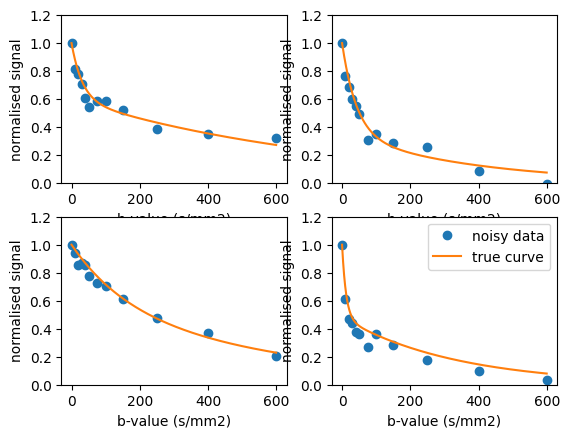

In [16]:
# set b-values at which we "measure" (i.e. simulate signal)
bvalues=[0, 10, 20, 30, 40, 50, 75, 100, 150, 250, 400, 600]

## Set the random seeds for reproducibility
np.random.seed(seed)
random.seed(seed)

## Loading the (simulated) dataset
data_sim, D, f, Dp = hf.sim_signal(SNR=(10,30),bvalues=bvalues,sims=30,seed=np.random.randint(1,10000))

## plotting some curves and data for visualisation
fig, axs = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        axs[i, j].plot(bvalues, data_sim[i+10*j,:], 'o')
        datapred=hf.ivim(np.arange(0,np.max(bvalues)), D[i+10*j], f[i+10*j], Dp[i+10*j], 1)
        axs[i, j].plot(np.arange(0,np.max(bvalues)), datapred)
        axs[i, j].set_ylim(0, 1.2)
        axs[i, j].set(xlabel='b-value (s/mm2)', ylabel='normalised signal')
plt.legend(('noisy data', 'true curve'))

## Splitting the data into training and validation
Here, we split our data into a training set, validation set and test set. Note that the current implementation only uses the training set and it is up to you (in your exercises) to also implement the validation and test run. At this point, we already split the data for you.

In [17]:
def sim_dat(bvalues,batch_size = 16,SNR=(10,40),sims=1000,seed=np.random.randint(1,10000)):
    with wandb.init(project="AI_for_medical_imaging", job_type="visualize data") as run:
        data_sim = hf.sim_signal(SNR=SNR,bvalues=bvalues,sims=sims,seed=seed)
        # Only for visualisation purposes: here we create our "Artifact" in wandb --> this allows viewing the data in your wandb account
        for i in range(4):
            #make b-value data pairs
            example_data=[[x,y] for (x,y) in zip(bvalues,data_sim[0][i])]
            # put it in a table
            table = wandb.Table(data=example_data, columns=["b-values", "signal"])
            #tell wandb to plot the table
            wandb.log({"data_plot " + str(i): wandb.plot.scatter(table, "b-values", "signal")})

        # here we split the data into train (70%), test (15%) and validation (15%) sets
        #split = int(np.floor(len(data_sim[0]) * 0.7))
        train_set, test_set, val_set = torch.utils.data.random_split([[data_sim[0][i,:],data_sim[1][i],data_sim[2][i],data_sim[3][i]] for i in range(len(data_sim[3]))],[0.7,0.15,0.15])
        #split = int(np.floor(len(rest) * 0.5))
        #test_set, val_set = torch.utils.data.random_split([[rest[0][i,:],rest[1][i],rest[2][i],rest[3][i]] for i in range(len(rest[3]))],[split, len(rest[0]) - split])

        # train loader loads the trianing data. We want to shuffle to make sure data order is modified each epoch and different data is selected each epoch.
        trainloader = torch.utils.data.DataLoader(train_set,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       drop_last=True)
        # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        inferloader = torch.utils.data.DataLoader(val_set,
                                       batch_size=min(batch_size,len(val_set)),
                                       shuffle=False,
                                       drop_last=False)
            # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        testloader = torch.utils.data.DataLoader(test_set,
                                       batch_size=min(batch_size,len(test_set)),
                                       shuffle=False,
                                       drop_last=False)
    return trainloader, inferloader, testloader
sim_dat(bvalues)

(<torch.utils.data.dataloader.DataLoader at 0x316793470>,
 <torch.utils.data.dataloader.DataLoader at 0x168062990>)

## Design a neural network

In [18]:
# funtion for stacking the layers and making the model
def make_model(n_inputs=len(bvalues), n_hidden=2, n_width=5, n_outputs=1, activation = "ReLU"):
    model = nn.Sequential()
    
    # Input layer
    model.add_module('input_layer', nn.Linear(n_inputs, n_width))
    if activation == "ReLU":
        model.add_module('input_ReLU', nn.ReLU())
    elif activation == "Sigmoid":
        model.add_module('input_Sigmoid', nn.Sigmoid())
    elif activation == "Tanh":
        model.add_module('input_Tanh', nn.Tanh())
    elif activation == "ELU":
        model.add_module('input_ELU', nn.ELU())
    
    # Hidden layers
    for i in range(1, n_hidden):
        model.add_module(f'hidden_linear_{i}', nn.Linear(n_width, n_width))
        if activation == "ReLU":
            model.add_module(f'hidden_ReLU_{i}', nn.ReLU())
        elif activation == "Sigmoid":
            model.add_module(f'hidden_Sigmoid_{i}', nn.Sigmoid())
        elif activation == "Tanh":
            model.add_module(f'hidden_Tanh_{i}', nn.Tanh())
        elif activation == "ELU":
            model.add_module(f'hidden_ELU_{i}', nn.ELU())
    
    # Output layer
    model.add_module('output_layer', nn.Linear(n_width, n_outputs))
    model.add_module('output_activation', nn.Sigmoid())

    model.apply(init_weights)
    return model

# function for initializing network weights for individual layers
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

train your first network

In [19]:
def train_network(name, epochs=200, learningrate=0.1, hidden_layers=2, seed=42, optimizer='SGD',bvalues=bvalues,batch_size=16,sims=1000, width=len(bvalues)):

    trainloader, inferloader, testloader = sim_dat(bvalues,batch_size=batch_size,sims=sims)

    model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, n_width=width, n_outputs=1)

    # initialize model --> we did this above, but during the exercise, you might be re-running this part of the script several times with different settings. This way we make sure you re-initiate the training and don't continue in the last model
    model.apply(init_weights)

    # initialize wandb
    wandb.init(
            project="AI_for_medical_imaging", job_type="training", name=name)

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False

    # Set default device. If GPU is available, the network will be trained on the GPU. Note that further down in the code, stuff will be sent ".to(device)" to make sure it is available on the GPU.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # the optimizer determines how strongly to update the network's weights based on the calculated loss.
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')

    # loop over epochs
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f = 0
        val_loss_f = 0
        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()
        #loop over all training data0
        SD_train = 0
        sys_train = 0
        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            batch=x[0].to(device)
            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            # put the data through the neural network
            f_pred = torch.flatten(model.forward(batch))
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            #add found loss to the train loss, to keep track of the loss this epoch
            train_loss_f += loss_f.item()
            # propogate the loss through the network (calculate d_wights/d_loss)
            loss_f.backward()
            # update all weights accoording to their derrivatives to the loss.
            optimizer.step()
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the trianing data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train += SD**2
            sys_train += sys
        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()
        # after training, set model to evaluation mode
        model.eval()
        # initialize error_metrics
        SD_val=0
        sys_val=0
        ######################your code here for validation loss#########################
        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        # put it in a table
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        #tell wandb to plot the table
        # note that some parameters are being logged which you still need to define in the validation loop!
        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})

        ## print output in terminal. Only useful for debugging when WandB does not work
        #print('epoch = ' + str(epoch) + ' train loss =' + str(train_loss_f/trainloader.__len__()) +' val loss =' + str(val_loss_f/inferloader.__len__()) + 'the systematic error is ' + str(sys_val) + ' and the random error is ' + str(SD_val))
    wandb.finish()
    #return val_test SD_test

train_network('test')

# First week (on schedule means finish by Friday) [if updated: 7-2-2025]
For these exercises, you will want to produce new cells that generate the outputs. The notebook cells should run and produce the figures without input of the examiners.

## 1A-C: train the neural network
Adapt the script above for your exercises A-C such that it produces the desired results and plots. Describe the results/intepertation in this text baloon.

A.	The current network implementation only looks at training data. This means that the network’s performance is over-estimated. Please use the validation set to monitor performance during training (note that we have already put the model on evaluation mode in line 59). At what point is the network fully trained? Explain how you know this. Show the effect from overfitting and underfitting.
B.	Similarly, use the test dataset to test for final performance. Explain why this is needed.
C.	Currently, standard gradient descent optimizer is being used to train the network, with a learning rate of 0.01. Investigate the performance of the network for different  optimizer (i.e. adam loss was discussed in the lecture) and explain what you see. What does the Adam  optimizer do differently from the SGD  optimizer that would make it perform better/differently?


In [20]:
def initialization(name, learning_rate=0.1, hidden_layers=2, seed=42, optimizer="SGD", bvalues=bvalues, batch_size=16, sims=1000, width=len(bvalues), activation="ReLU", n_outputs=1):
    trainloader, inferloader, testloader = sim_dat(bvalues,batch_size=batch_size,sims=sims)

    model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, n_width=width, n_outputs=n_outputs, activation=activation)

    model.apply(init_weights)

    # initialize wandb
    wandb.init(
            project="AI_for_medical_imaging", job_type="training", name=name)

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False

    # Set default device. If GPU is available, the network will be trained on the GPU. Note that further down in the code, stuff will be sent ".to(device)" to make sure it is available on the GPU.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # the optimizer determines how strongly to update the network's weights based on the calculated loss.
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')

    return model, trainloader, inferloader, testloader, device, loss_module, optimizer
    

In [21]:
def train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200):
    # initialize lists to save errors at each epoch for plotting
    train_losses, val_losses, sys_train_list, sys_val_list, SD_train_list, SD_val_list = [], [], [], [], [], []

    # loop over epochs
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f = 0
        val_loss_f = 0
        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()
        #loop over all training data0
        SD_train = 0
        sys_train = 0

        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            batch=x[0].to(device)
            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            # put the data through the neural network
            f_pred = torch.flatten(model.forward(batch))
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            #add found loss to the train loss, to keep track of the loss this epoch
            train_loss_f += loss_f.item()
            # propogate the loss through the network (calculate d_wights/d_loss)
            loss_f.backward()
            # update all weights accoording to their derrivatives to the loss.
            optimizer.step()
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the trianing data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train += SD**2
            sys_train += sys
        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()
        sys_train_list.append(sys_train)
        SD_train_list.append(SD_train)
        train_losses.append(train_loss_f / trainloader.__len__())

        # after training, set model to evaluation mode
        model.eval()
        # initialize error_metrics
        SD_val=0
        sys_val=0

        ######################your code here for validation loss#########################
        for x in inferloader:
            batch = x[0].to(device)
            f_ref_val = torch.flatten(x[2].to(device))
            f_pred_val = torch.flatten(model.forward(batch))
            loss_f = loss_module(f_pred_val, f_ref_val)
            val_loss_f += loss_f.item()
            SD, sys = hf.error_metrics(f_pred_val.cpu().detach().numpy(),f_ref_val.cpu().detach().numpy())
            SD_val += SD**2
            sys_val += sys
        
        SD_val = np.sqrt(SD_val / inferloader.__len__())
        sys_val = sys_val / inferloader.__len__()
        sys_val_list.append(sys_val)
        SD_val_list.append(SD_val)
        val_losses.append(val_loss_f / inferloader.__len__())


        wandb.log({"loss/train":train_losses[-1], "loss/val":val_losses[-1], "error/random error":SD_train, "error/systematic error":sys_train})
        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        example_data_val = [[x,y] for (x,y) in zip(f_ref_val.cpu().detach().numpy(),f_pred_val.cpu().detach().numpy())]
        # put it in a table
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
        table_val = wandb.Table(data=example_data_val, columns=["f_ref_val", "f_pred_val"])
        #tell wandb to plot the table
        # note that some parameters are being logged which you still need to define in the validation loop!
        if epoch % 10 == 0:
            wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_train,"error/systematic error":sys_train,"data_plot epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'epoch{epoch}')})
            wandb.log({"data_plot_val epoch " + str(epoch): wandb.plot.scatter(table_val, "f_ref_val", "f_pred_val", title=f'epoch{epoch}')})


    return train_losses, val_losses, SD_val_list, sys_val_list, SD_train_list, sys_train_list

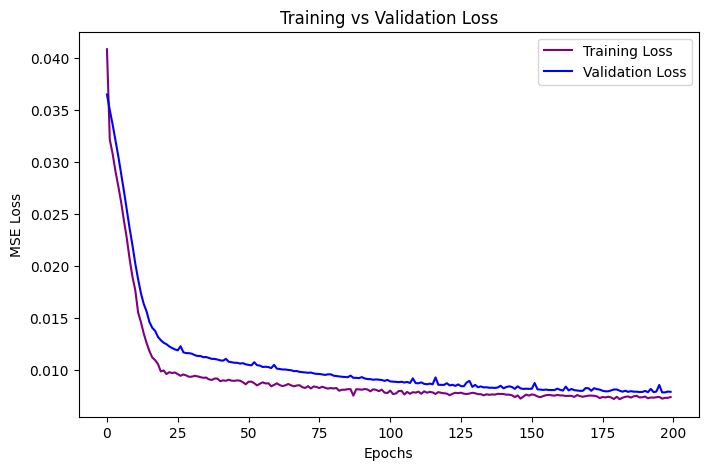

In [22]:
## Plotting Training and Validation loss
model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test")
train_losses, val_losses, SD_val_list, sys_val_list, SD_train_list, sys_train_list = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

plt.figure(figsize = (8,5))
plt.plot(train_losses, label = "Training Loss", color = "purple")
plt.plot(val_losses, label = "Validation Loss", color = "blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### Answer A
When both losses decrease and stabilize and there is a small gap between training and validation loss the network is fully trained. If the training loss continues decreasing, but validation loss starts increasing there is overfitting. Otherwise, if both the training and validation loss are high there is underfitting. In this graph we can see that around 20 epochs both losses stabilize at a low value, meaning the network is fully trained.

What changes in our model would cause overfitting? 
- Decreasing the amount of training data (model memorizes instead of generalizing)
- Increasing the number of hidden layers (model learns too many details of the training data)
- Increasing the number of neurons in the hidden layers (model learns too many details of the training data)
- Increasing the number of epochs (model memorizes instead of generalizing)

What changes in our model would cause underfitting?
- Decreasing the number of hidden layers 
- Decreasing the number of neurons in the hidden layers 
- Decreasing the number of epochs 


#### Answer B

Why do we need a testing set?
- The testing set is used only at the end to evaluate final model performance. It provides an unbiased estimate of how well the model generalizes to unseen data.

In [23]:
def test_network(model, testloader, device, loss_module):
    # set model to evaluation mode
    model.eval()
    test_loss = 0

    f_ref_list, f_pred_list = [], []

    SD_test, sys_test = 0, 0

    with torch.no_grad():
        for x in testloader:
            batch = x[0].to(device)
            f_ref = torch.flatten(x[2].to(device))
            f_pred = torch.flatten(model.forward(batch))
            loss_f = loss_module(f_pred, f_ref)
            test_loss += loss_f.item()
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            SD_test += SD**2
            sys_test += sys
            f_ref_list.append(f_ref)
            f_pred_list.append(f_pred)

        SD_test = np.sqrt(SD_test / testloader.__len__())
        sys_test = sys_test / testloader.__len__()
    
    
    test_loss = test_loss / testloader.__len__()
    
    return f_ref_list, f_pred_list, test_loss, SD_test, sys_test

In [24]:
model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test")
train_losses, val_losses, SD_val_list, sys_val_list, SD_train_list, sys_train_list = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

f_ref_list, f_pred_list, testing_loss, SD_test, sys_test = test_network(model, testloader, device, loss_module)

training_loss = train_losses[-1]
validation_loss = val_losses[-1]

print(f"Training Loss: {training_loss}")
print(f"Validation Loss: {validation_loss}")
print(f"Testing Loss: {testing_loss}")

Training Loss: 0.006809114760091138
Validation Loss: 0.007881981658283622
Testing Loss: 0.008492846717126667


The the test loss is close to the validation loss, which means the model generalizes well.

#### Answer C
To test the different optimizers, we will get the mean of the training, validation and testing errors for multiple runs.

In [25]:
n_runs = 3
training_loss_sgd, validation_loss_sgd, testing_loss_sgd = [], [], []
training_loss_adam, validation_loss_adam, testing_loss_adam = [], [], []
training_loss_rmsprop, validation_loss_rmsprop, testing_loss_rmsprop = [], [], []
training_loss_adagrad, validation_loss_adagrad, testing_loss_adagrad = [], [], []

for i in range(n_runs):
    # SGD optimizer
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test")
    train_losses, val_losses, SD_val_list, sys_val_list, SD_train_list, sys_train_list = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss_sgd, SD_test, sys_test = test_network(model, testloader, device, loss_module)

    training_loss_sgd.append(train_losses[-1])
    validation_loss_sgd.append(val_losses[-1])
    testing_loss_sgd.append(test_loss_sgd)

    # Adam optimizer
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", optimizer="Adam")
    train_losses, val_losses, SD_val_list, sys_val_list, SD_train_list, sys_train_list = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss_adam, SD_test, sys_test = test_network(model, testloader, device, loss_module)

    training_loss_adam.append(train_losses[-1])
    validation_loss_adam.append(val_losses[-1])
    testing_loss_adam.append(test_loss_adam)

    # RMSprop optimizer
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", optimizer="RMSprop")
    train_losses, val_losses, SD_val_list, sys_val_list, SD_train_list, sys_train_list = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss_rmsprop, SD_test, sys_test = test_network(model, testloader, device, loss_module)

    training_loss_rmsprop.append(train_losses[-1])
    validation_loss_rmsprop.append(val_losses[-1])
    testing_loss_rmsprop.append(test_loss_rmsprop)

    # Adagrad optimizer
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", optimizer="Adagrad")
    train_losses, val_losses, SD_val_list, sys_val_list, SD_train_list, sys_train_list = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss_adagrad, SD_test, sys_test = test_network(model, testloader, device, loss_module)

    training_loss_adagrad.append(train_losses[-1])
    validation_loss_adagrad.append(val_losses[-1])
    testing_loss_adagrad.append(test_loss_adagrad)

# Calculating the mean values for n runs
training_loss_sgd = np.mean(training_loss_sgd)
validation_loss_sgd = np.mean(validation_loss_sgd)
testing_loss_sgd = np.mean(testing_loss_sgd)

training_loss_adam = np.mean(training_loss_adam)
validation_loss_adam = np.mean(validation_loss_adam)
testing_loss_adam = np.mean(testing_loss_adam)

training_loss_rmsprop = np.mean(training_loss_rmsprop)
validation_loss_rmsprop = np.mean(validation_loss_rmsprop)
testing_loss_rmsprop = np.mean(testing_loss_rmsprop)

training_loss_adagrad = np.mean(training_loss_adagrad)
validation_loss_adagrad = np.mean(validation_loss_adagrad)
testing_loss_adagrad = np.mean(testing_loss_adagrad)

In [26]:
from tabulate import tabulate

# Define the loss values
data = [
    ["Adam", training_loss_adam, validation_loss_adam, testing_loss_adam],
    ["SGD", training_loss_sgd, validation_loss_sgd, testing_loss_sgd],
     ["RMSprop", training_loss_rmsprop, validation_loss_rmsprop, testing_loss_rmsprop],
    ["Adagrad", training_loss_adagrad, validation_loss_adagrad, testing_loss_adagrad]]


# Define table headers
headers = ["Optimizer", "Training Loss", "Validation Loss", "Testing Loss"]

# Print the table
print(tabulate(data, headers=headers, tablefmt="grid"))

+-------------+-----------------+-------------------+----------------+
| Optimizer   |   Training Loss |   Validation Loss |   Testing Loss |
+=============+=================+===================+================+
| Adam        |      0.00778738 |        0.00887702 |     0.0069336  |
+-------------+-----------------+-------------------+----------------+
| SGD         |      0.00722294 |        0.008422   |     0.00674064 |
+-------------+-----------------+-------------------+----------------+
| RMSprop     |      0.461651   |        0.432921   |     0.45941    |
+-------------+-----------------+-------------------+----------------+
| Adagrad     |      0.00669746 |        0.00815439 |     0.00664068 |
+-------------+-----------------+-------------------+----------------+


Among the tested optimizers, Adagrad achieved the lowest training, validation, and testing losses, making it the most effective choice. Its adaptive learning rate per parameter allowed it to make consistent progress while avoiding large, unstable updates.

Adam also performed well, with slightly higher losses than Adagrad. Its combination of adaptive learning rates and momentum helped with stable convergence, but it did not outperform Adagrad in this case.

SGD had competitive performance but showed slightly higher losses. Since it uses a fixed learning rate, it is more susceptible to noisy gradients and slower convergence.

RMSprop, on the other hand, performed significantly worse than the others, with much higher training, validation, and testing losses. While it also adapts learning rates, its performance suggests it may not have been well-suited for this problem.

D.	Return back to SGD. Test how the performance depends on the learning rate. This can be done by plotting the systematic (sys_test) and random (SD_test) errors as function of learning rate (10<LR<0.0000001; steps in order of magnitude; e.g. 10, 1, 0.1, ….).
##### Plot the performance (sys_val and SD_val) as function of the learning rate and add this to your report. Explain what you see (hint: take a look at the loss curves).
easiest is to save the final performance and plot it in the jupyter notebook.

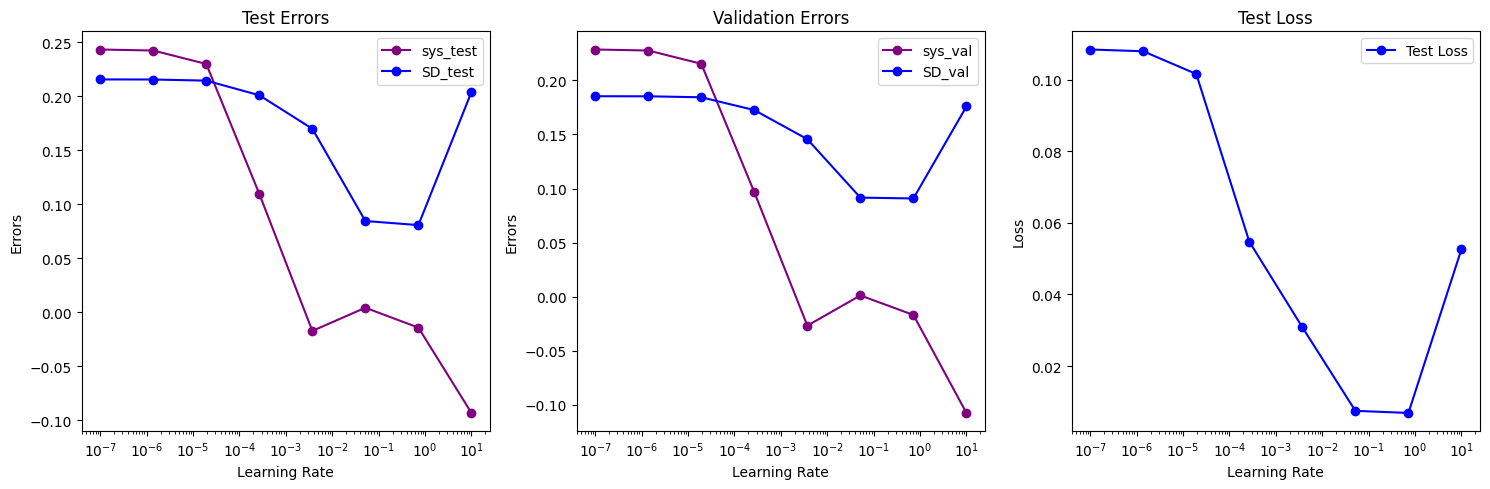

In [27]:
learning_rates = np.logspace(start = -7, stop = 1, num=8, endpoint=True, base=10.0)

sys_test_list = []
sys_val_list = []
SD_test_list = []
SD_val_list = []
test_loss_list = []

for learning_rate in learning_rates:
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", learning_rate=learning_rate)
    train_losses, val_losses, SD_val, sys_val, SD_train, sys_train = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss, SD_test, sys_test = test_network(model, testloader, device, loss_module)

    sys_test_list.append(sys_test)
    sys_val_list.append(sys_val[-1])
    SD_test_list.append(SD_test)
    SD_val_list.append(SD_val[-1])
    test_loss_list.append(test_loss)

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

# Test Errors
axes[0].plot(learning_rates, sys_test_list, label="sys_test", marker='o', color="purple")
axes[0].plot(learning_rates, SD_test_list, label="SD_test", marker='o', color="blue")
axes[0].set_xscale("log")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Errors")
axes[0].set_title("Test Errors")
axes[0].legend()

# Validation Errors
axes[1].plot(learning_rates, sys_val_list, label="sys_val", marker='o', color="purple")
axes[1].plot(learning_rates, SD_val_list, label="SD_val", marker='o', color="blue")
axes[1].set_xscale("log")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Errors")
axes[1].set_title("Validation Errors")
axes[1].legend()

# Test Loss
axes[2].plot(learning_rates, test_loss_list, label="Test Loss", marker='o', color="blue")
axes[2].set_xscale("log")
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Loss")
axes[2].set_title("Test Loss")
axes[2].legend()

plt.tight_layout() 
plt.show()


#### Answer D
At high learning rates we see the test loss increase whcih indicates that the model is truggling to converge. This explains why the error is negative at high learning rates. At low learning rates the model converges well and the error is low. As the learning rate decreases to a moderate range (e.g., 0.1 to 0.001), the errors decrease, indicating stable convergence and better generalization. This range typically provides the best balance between speed and accuracy. However, at extremely low learning rates (e.g., below 0.0001), the model updates are too small, leading to slow convergence or stagnation, where the error remains high due to insufficient progress. Observing the loss curves, we can see that high learning rates cause erratic fluctuations, while very low learning rates result in excessively slow improvements.

or
At very small learning rates ($\le 10^{-5}$), both the validation and test errors remain high, indicating a too slow convergence. 

As the learning rate increases above $10^{-4}$, we see a significant improvement in the sys_test and sys_val curves, which drop sharply. The SD_test and SD_val curves also decrease, though more gradually. The test loss follows a similar pattern, starting high at small learning rates, decreasing steadily, and reaching its lowest point around $10^{-2}$.

At very high learning rates ($>10^{0}=1$), the error starts increasing again, and the loss rises, indicating potential instability and divergence.

Based on these observations, the optimal learning rate is between 0.01 and 0.1, as it achieves the lowest errors and test loss while maintaining stability.

E.	Plot the performance (sys_val and SD_val) as function of the width (number of neurons per layer: 5, 10, 20, 50, 100) and depth (number of hidden layers: 1, 2, ..., 8) of the network and add these to the report. Discuss how width and depth may influence the network; if it has this behaviour in your data, highlight it; if not, explain why it may not occur in your dataset.

Hint: currently, the width of the network copies the width of the data, so you need to uncouple the input width from the network width by adapting the "make model" code.
Tip: you only need to plot different widths for 1 depth (e.g. 2) and different depths for 1 width (e.g. 10).
Tip: possibly some effects get clearer when more training data is simulated ("sims" in data_sim). But also note that having too much training data may hide some of the effects from other exercises, so don't forget to revert it.

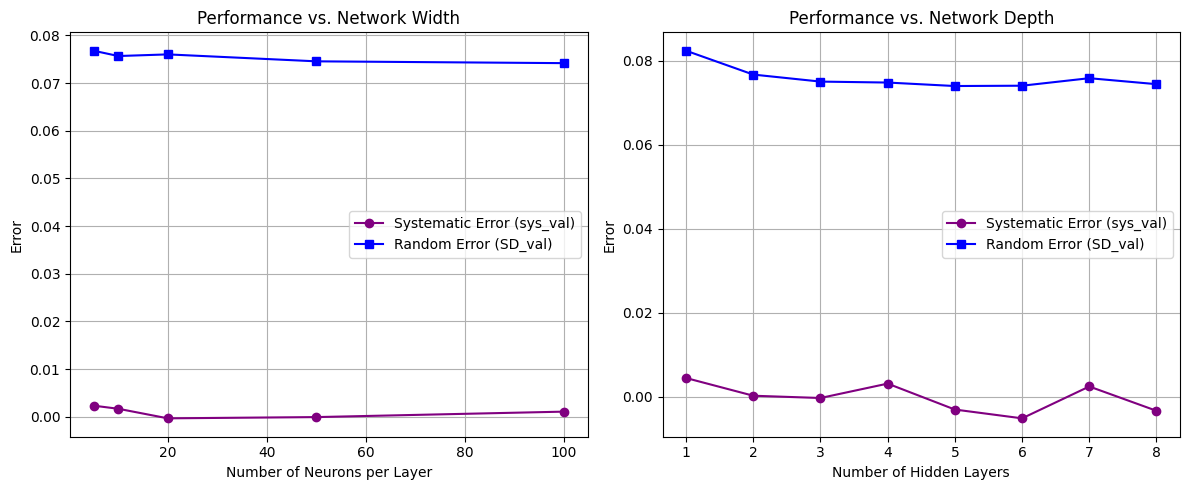

In [28]:
# Example data (Replace with actual results)
widths = [5, 10, 20, 50, 100]
depths = np.arange(1, 9)

test_loss_width = []
sys_val_width = []
SD_val_width = []

# width is the number of neurons per layer
for width in widths:
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", sims = 10000, width=width)
    train_losses, val_losses, SD_val, sys_val, SD_train, sys_train = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss, SD_test, sys_test = test_network(model, testloader, device, loss_module)

    test_loss_width.append(test_loss)
    sys_val_width.append(sys_val[-1])
    SD_val_width.append(SD_val[-1])

test_loss_depth = []
sys_val_depth = []
SD_val_depth = []

# depth is the number of hidden layers
for depth in depths:
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", sims = 10000, hidden_layers=depth)
    train_losses, val_losses, SD_val, sys_val, SD_train, sys_train = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss, SD_test, sys_test = test_network(model, testloader, device, loss_module)

    test_loss_depth.append(test_loss)
    sys_val_depth.append(sys_val[-1])
    SD_val_depth.append(SD_val[-1])


# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot performance vs. width
axes[0].plot(widths, sys_val_width, label="Systematic Error (sys_val)", marker="o", color="purple")
axes[0].plot(widths, SD_val_width, label="Random Error (SD_val)", marker="s", color="blue")
axes[0].set_xlabel("Number of Neurons per Layer")
axes[0].set_ylabel("Error")
axes[0].set_title("Performance vs. Network Width")
axes[0].legend()
axes[0].grid()

# Plot performance vs. depth
axes[1].plot(depths, sys_val_depth, label="Systematic Error (sys_val)", marker="o", color="purple")
axes[1].plot(depths, SD_val_depth, label="Random Error (SD_val)", marker="s", color="blue")
axes[1].set_xlabel("Number of Hidden Layers")
axes[1].set_ylabel("Error")
axes[1].set_title("Performance vs. Network Depth")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

#### Answer E
Increasing the width of the network generally improves performance, as it allows the model to learn more complex patterns in the data. However, due to the simplicity of this data we see that increasing the number of neurons per layer does not affect the performance after a snmall number of neurons. Increasing the depth of the network can also improve performance by enabling the model to learn hierarchical representations of the data. Deeper networks can capture more abstract features by composing simpler patterns learned in earlier layers. However, again, due to the simplicity of the data we see that increasing the depth of the network does not affect the performance after a small number of layers.

F.	Try different batch sizes (1, 4, 16, 64, 128, 516).Explain the behavior of the network you see.What is the effect of having smaller batches? And larger batches?

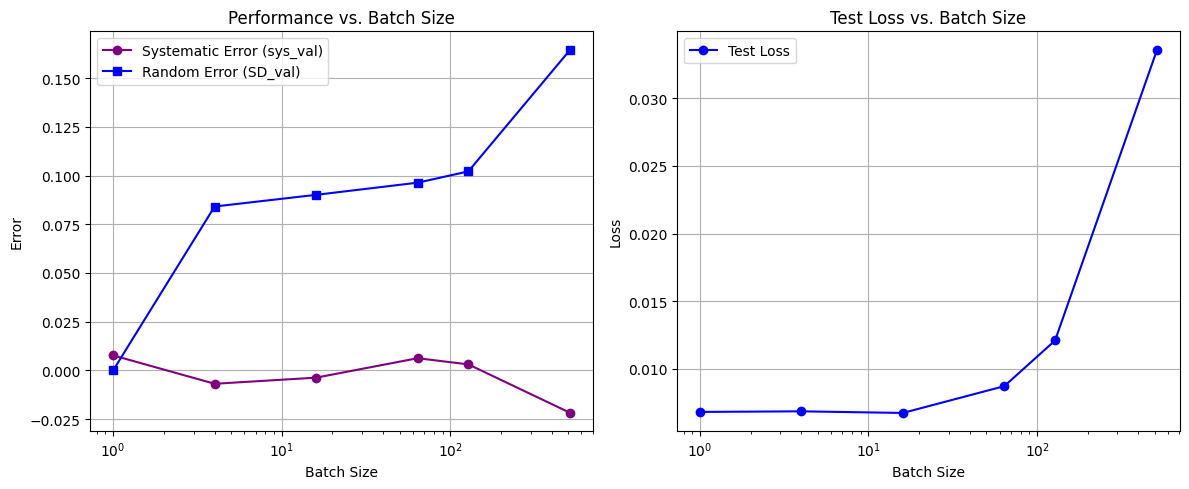

In [29]:
batch_sizes = [1, 4, 16, 64, 128, 516]

test_loss_batch = []
sys_val_batch = []
SD_val_batch = []
test_loss_batch = []

for batch_size in batch_sizes:
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", batch_size=batch_size)
    train_losses, val_losses, SD_val, sys_val, SD_train, sys_train = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    f_ref_list, f_pred_list, test_loss, SD_test, sys_test = test_network(model, testloader, device, loss_module)
    sys_val_batch.append(sys_val[-1])
    SD_val_batch.append(SD_val[-1])
    test_loss_batch.append(test_loss)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot performance vs. batch size
axes[0].plot(batch_sizes, sys_val_batch, label="Systematic Error (sys_val)", marker="o", color="purple")
axes[0].plot(batch_sizes, SD_val_batch, label="Random Error (SD_val)", marker="s", color="blue")
axes[0].set_xscale("log")
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Error")
axes[0].set_title("Performance vs. Batch Size")
axes[0].legend()
axes[0].grid()

# Plot test loss vs. batch size
axes[1].plot(batch_sizes, test_loss_batch, label="Test Loss", marker="o", color="blue")
axes[1].set_xscale("log")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Loss")
axes[1].set_title("Test Loss vs. Batch Size")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


#### Answer F
The batch size plays a crucial role in determining the speed, stability, and generalization of training. Smaller batch sizes allow for more frequent updates to the model, which can lead to faster convergence and improved generalization. However, they also introduce more noise into the optimization process, making training less stable and potentially slowing down overall convergence. In contrast, larger batch sizes provide more stable updates by averaging over more samples, which helps smooth out noisy gradients and accelerate training. However, they reduce the frequency of updates, which can slow convergence and impact generalization.

In terms of error behavior, systematic error initially decreases as batch size increases but then starts to rise. At the same time, random error increases sharply at first and then plateaus. This suggests that while smaller batch sizes reduce variance and random error, they may introduce bias. Conversely, larger batch sizes minimize variance but at the cost of increased systematic error.

The second plot further illustrates the effect of batch size on test loss, showing a steady increase. This indicates that as batch size grows, the model's ability to generalize diminishes, likely due to reduced update frequency and overfitting to the training data.

For this reason, we will use smaller batch sizes, such as 4, 8, or 16, in order to maintain a good balance between stability and generalization.

G.Chose 3 hidden layers, width of 40,  learning rate of 0.1 and batch size of 2. Now train the network for 3000 epochs. At what point in the network fully trained? How do you see this? Does any overfitting occur?

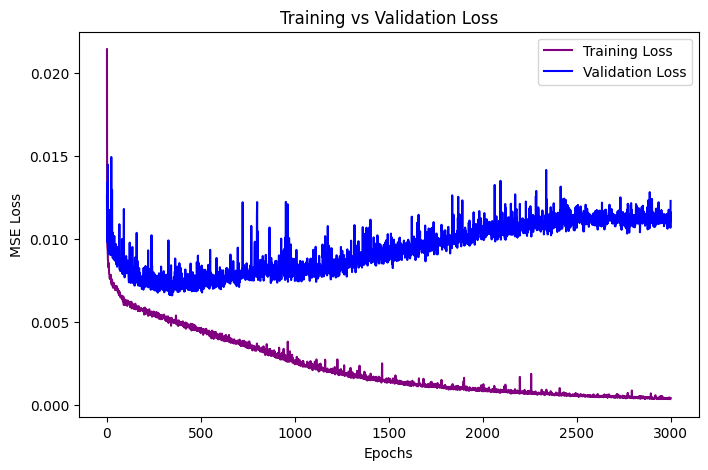

In [30]:
hidden_layers = 3
width = 40
learning_rate = 0.1
batch_size = 2
epochs = 3000

model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", learning_rate=learning_rate, hidden_layers=hidden_layers, width=width, batch_size=batch_size)
train_losses, val_losses, SD_val, sys_val, SD_train, sys_train = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=epochs)

f_ref_list, f_pred_list, test_loss, SD_test, sys_test = test_network(model, testloader, device, loss_module)

plt.figure(figsize = (8,5))
plt.plot(train_losses, label = "Training Loss", color = "purple")
plt.plot(val_losses, label = "Validation Loss", color = "blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### Answer G
We can see that training loss continues decreasing over the epochs, but validation loss starts increasing, which is a sign that there is overfitting. The model is memorizing the training data instead of generalizing to unseen data. This is likely due to the large number of epochs, which allows the model to learn too many details of the training data. 

The network if fully trained at around 500 epochs as the validation error stabilises at its lowest value. After that point the validation error starts increasing, which is a sign that overfitting is happenig due to the too high of epochs.

# Second week (on schedule means finish by Wednesday) [if updated: 12-2-2025]
H.	Currently, the model uses a Relu activation function. Test the effect of different activation funtions on the network performance. Show how well does a sigmoid or ELU work (i.e. what is the effect on performance)?

Note, you can either:
- adapt the scripts above to program this "neatly" as input parameter.
- redefine new "programs" below that have the new properties you want.

Note that in the case of option 1, your programs need to stay backwards compatible, as examiners will need to be able to rerun your code and reproduce your results!

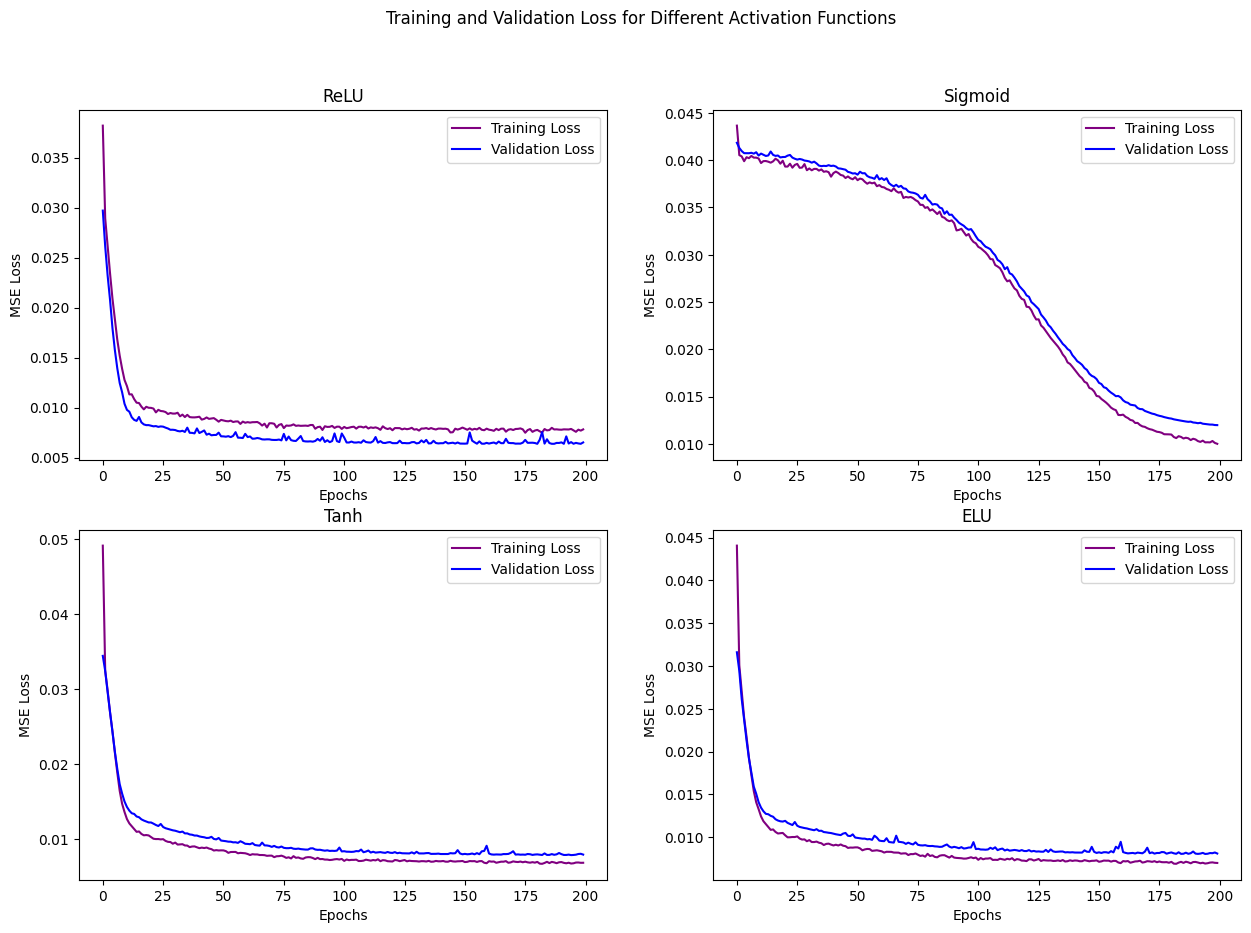

In [31]:
# testing the performance of the network for different activation functions
activations = ["ReLU", "Sigmoid", "Tanh", "ELU"]

training_loss_Relu, validation_loss_Relu  = 0, 0
training_loss_Sigmoid, validation_loss_Sigmoid = 0, 0
training_loss_Tanh, validation_loss_Tanh = 0, 0
training_loss_ELU, validation_loss_ELU = 0, 0

for activation in activations:
    model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", activation=activation)
    train_losses_f, val_losses_f, SD_val, sys_val, SD_train, sys_train = train_network(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

    if activation == "ReLU":
        training_loss_Relu = train_losses_f
        validation_loss_Relu = val_losses_f
       
    elif activation == "Sigmoid":
        training_loss_Sigmoid = train_losses_f
        validation_loss_Sigmoid = val_losses_f
        
    elif activation == "Tanh":
        training_loss_Tanh = train_losses_f
        validation_loss_Tanh = val_losses_f
      
    elif activation == "ELU":
        training_loss_ELU = train_losses_f
        validation_loss_ELU = val_losses_f
       


# Plotting the training and validation for each activation function
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training and Validation Loss for Different Activation Functions')

axs[0, 0].plot(training_loss_Relu, label="Training Loss", color="purple")
axs[0, 0].plot(validation_loss_Relu, label="Validation Loss", color="blue")
axs[0, 0].set_title("ReLU")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("MSE Loss")
axs[0, 0].legend()

axs[0, 1].plot(training_loss_Sigmoid, label="Training Loss", color="purple")
axs[0, 1].plot(validation_loss_Sigmoid, label="Validation Loss", color="blue")
axs[0, 1].set_title("Sigmoid")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("MSE Loss")
axs[0, 1].legend()

axs[1, 0].plot(training_loss_Tanh, label="Training Loss", color="purple")
axs[1, 0].plot(validation_loss_Tanh, label="Validation Loss", color="blue")
axs[1, 0].set_title("Tanh")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("MSE Loss")
axs[1, 0].legend()

axs[1, 1].plot(training_loss_ELU, label="Training Loss", color="purple")
axs[1, 1].plot(validation_loss_ELU, label="Validation Loss", color="blue")
axs[1, 1].set_title("ELU")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("MSE Loss")
axs[1, 1].legend()

plt.show()

So far, we simualted a small amount of data, as it is easier to show overfitting etc. Note that you may want to simulate somewhat more data for this and the following exercises. This can be achieved by setting sims=100000 for the following exercises

I.	Let the network also predict D and Dp (note x[1] and x[3] are D and Dp respectively). Show the loss curve of D and Dp and explain how you can see that they have been implemented properly/the model is learning them.
o	The network will need more than 1 output --> tip, use loss_D.backward(retain_graph=True) for the first two losses to remember losses and propogate all 3 losses backward in turn
o	Alternatively, you could train 3 networks simultaniously
Note that 0<f<1 on avergae is orders of magnitude larger than D and Dp. To ensure all three losses equally affect the network weights you may want to enlarge the loss of D and Dp by multiplying them with some value.


In [32]:

def train_network_updated(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200, scaling_factor=100):
    # initialize lists to save errors at each epoch for plotting
    train_losses_f, train_losses_D, train_losses_Dp, val_losses_f, val_losses_D, val_losses_Dp = [], [], [], [], [], []
    sys_train_list_f, SD_train_list_f, sys_train_list_D, SD_train_list_D, sys_train_list_Dp, SD_train_list_Dp = [], [], [], [], [], []
    
    # loop over epochs
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f, train_loss_D, train_loss_Dp = 0, 0, 0
        val_loss_f, val_loss_D, val_loss_Dp = 0, 0, 0

        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()
        #loop over all training data
        
        SD_train_f, SD_train_D, SD_train_Dp = 0, 0, 0
        sys_train_f, sys_train_D, sys_train_Dp = 0, 0, 0
        
        for batch in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            x = batch[0].to(device)
            f_true = torch.flatten(batch[2].to(device))
            D_true = torch.flatten(batch[1].to(device))
            Dp_true = torch.flatten(batch[3].to(device))

            outputs = model(x)
            f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]

            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_true)
            loss_D = loss_module(D_pred, D_true) * scaling_factor
            loss_Dp = loss_module(Dp_pred, Dp_true) * scaling_factor

            # add found loss to the train loss, to keep track of the loss this epoch
            train_loss_f += loss_f.item()
            train_loss_D += loss_D.item()
            train_loss_Dp += loss_Dp.item()
        
            # propogate the loss through the network (calculate d_weights/d_loss)
            loss_f.backward(retain_graph = True)
            loss_D.backward(retain_graph = True)
            loss_Dp.backward()

            # update all weights accoording to their derrivatives to the loss.
            optimizer.step()
            
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_true.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the trianing data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train_f += SD**2
            sys_train_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(),D_true.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the trianing data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train_D += SD**2
            sys_train_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(),Dp_true.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the trianing data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train_Dp += SD**2
            sys_train_Dp += sys

        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train_f, sys_train_f = np.sqrt(SD_train_f/trainloader.__len__()), sys_train_f/trainloader.__len__()
        SD_train_D, sys_train_D = np.sqrt(SD_train_D/trainloader.__len__()), sys_train_D/trainloader.__len__()
        SD_train_Dp, sys_train_Dp = np.sqrt(SD_train_Dp/trainloader.__len__()), sys_train_Dp/trainloader.__len__()

        sys_train_list_f.append(sys_train_f)
        SD_train_list_f.append(SD_train_f)
        sys_train_list_D.append(sys_train_D)
        SD_train_list_D.append(SD_train_D)
        sys_train_list_Dp.append(sys_train_Dp)
        SD_train_list_Dp.append(SD_train_Dp)
        
        train_losses_f.append(train_loss_f / trainloader.__len__())
        train_losses_D.append(train_loss_D / trainloader.__len__())
        train_losses_Dp.append(train_loss_Dp / trainloader.__len__())

        # after training, set model to evaluation mode
        model.eval()
        # initialize error_metrics
        sys_val_list_f, SD_val_list_f, sys_val_list_D, SD_val_list_D, sys_val_list_Dp, SD_val_list_Dp = [], [], [], [], [], []
        SD_val_f, SD_val_D, SD_val_Dp = 0, 0, 0
        sys_val_f, sys_val_D, sys_val_Dp = 0, 0, 0
        
        # validation
        for batch in inferloader:
            x, f_true, D_true, Dp_true = batch
            x, f_true, D_true, Dp_true = x.to(device), f_true.to(device), D_true.to(device), Dp_true.to(device)
            
            outputs = model(x)
            f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]


            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_true)
            loss_D = loss_module(D_pred, D_true) * 100 # Scaling factor
            loss_Dp = loss_module(Dp_pred, Dp_true) * 100 # Scaling factor

            val_loss_f += loss_f.item()
            val_loss_D += loss_D.item()
            val_loss_Dp += loss_Dp.item()
            
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_true.cpu().detach().numpy())
            SD_val_f += SD**2
            sys_val_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(),D_true.cpu().detach().numpy())
            SD_val_D += SD**2
            sys_val_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(),Dp_true.cpu().detach().numpy())
            SD_val_Dp += SD**2
            sys_val_Dp += sys

        SD_val_f, sys_val_f = np.sqrt(SD_val_f/inferloader.__len__()), sys_val_f/inferloader.__len__()
        SD_val_D, sys_val_D = np.sqrt(SD_val_D/inferloader.__len__()), sys_val_D/inferloader.__len__()
        SD_val_Dp, sys_val_Dp = np.sqrt(SD_val_Dp/inferloader.__len__()), sys_val_Dp/inferloader.__len__()

        sys_val_list_f.append(sys_val_f)
        SD_val_list_f.append(SD_val_f)
        sys_val_list_D.append(sys_val_D)
        SD_val_list_D.append(SD_val_D)
        sys_val_list_Dp.append(sys_val_Dp)
        SD_val_list_Dp.append(SD_val_Dp)        
        
        val_losses_f.append(val_loss_f / inferloader.__len__())
        val_losses_D.append(val_loss_D / inferloader.__len__())
        val_losses_Dp.append(val_loss_Dp / inferloader.__len__())

        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        # Make data pairs for f, D, and Dp
        example_data = [[x, y, d_true, d_pred, dp_true, dp_pred] 
                        for (x, y, d_true, d_pred, dp_true, dp_pred) in 
                        zip(f_true.cpu().detach().numpy(), f_pred.cpu().detach().numpy(),
                            D_true.cpu().detach().numpy(), D_pred.cpu().detach().numpy(),
                            Dp_true.cpu().detach().numpy(), Dp_pred.cpu().detach().numpy())]

        # Create a wandb table with new columns
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred", "D_ref", "D_pred", "Dp_ref", "Dp_pred"])

        # Log additional metrics in wandb every 10 epochs
        if epoch % 10 == 0:
            wandb.log({
                "loss/train_f": train_loss_f / trainloader.__len__(),
                "loss/val_f": val_loss_f / inferloader.__len__(),
                "loss/train_D": train_loss_D / trainloader.__len__(),
                "loss/val_D": val_loss_D / inferloader.__len__(),
                "loss/train_Dp": train_loss_Dp / trainloader.__len__(),
                "loss/val_Dp": val_loss_Dp / inferloader.__len__(),
                
                "error/random error_f": SD_train_f,
                "error/systematic error_f": sys_train_f,
                "error/random error_D": SD_train_D,
                "error/systematic error_D": sys_train_D,
                "error/random error_Dp": SD_train_Dp,
                "error/systematic error_Dp": sys_train_Dp,

                # New plots for D and Dp
                "data_plot_f_epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'f: epoch {epoch}'),
                "data_plot_D_epoch " + str(epoch): wandb.plot.scatter(table, "D_ref", "D_pred", title=f'D: epoch {epoch}'),
                "data_plot_Dp_epoch " + str(epoch): wandb.plot.scatter(table, "Dp_ref", "Dp_pred", title=f'Dp: epoch {epoch}')
            })

    wandb.finish()

    return train_losses_f, train_losses_D, train_losses_Dp, val_losses_f, val_losses_D, val_losses_Dp

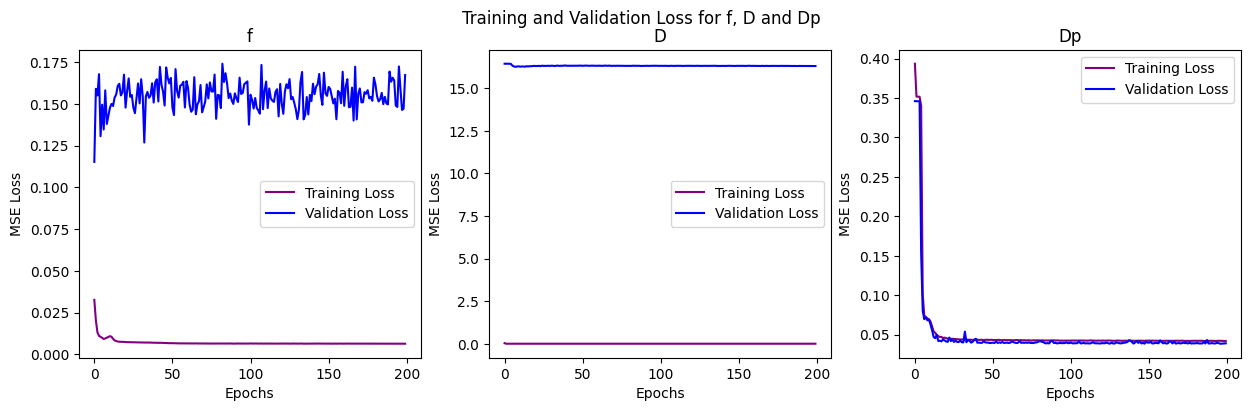

In [33]:
model, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", n_outputs=3, sims=10000)
train_losses_f, train_losses_D, train_losses_Dp, val_losses_f, val_losses_D, val_losses_Dp = train_network_updated(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200)

# Plotting training and validation losses for f, D and Dp
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Training and Validation Loss for f, D and Dp')

axs[0].plot(train_losses_f, label="Training Loss", color="purple")
axs[0].plot(val_losses_f, label="Validation Loss", color="blue")
axs[0].set_title("f")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MSE Loss")
axs[0].legend()

axs[1].plot(train_losses_D, label="Training Loss", color="purple")
axs[1].plot(val_losses_D, label="Validation Loss", color="blue")
axs[1].set_title("D")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("MSE Loss")
axs[1].legend()

axs[2].plot(train_losses_Dp, label="Training Loss", color="purple")
axs[2].plot(val_losses_Dp, label="Validation Loss", color="blue")
axs[2].set_title("Dp")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("MSE Loss")
axs[2].legend()

plt.show()

J.	Use the sigmoid in the final layer to constrain 0.5e-3 <D< 3.5e-3; 0<f<1; 5e-3<D*<130e-3. Explain how you did this.
Note: D, f and D* are in very different parameter value ranges, and hence their RMS is too. A network will focus on the largest loss. You may want to scale the RMS to similar ranges for the network to consider all 3 parameters during optmizing.
Also note: You may want to play with hyperparameters.

In [82]:
def train_network_scaling(model, trainloader, inferloader, device, loss_module, optimizer, epochs=200, scaling_factor=100):
    # initialize lists to save errors at each epoch for plotting
    train_losses_f, train_losses_D, train_losses_Dp, val_losses_f, val_losses_D, val_losses_Dp = [], [], [], [], [], []
    sys_train_list_f, SD_train_list_f, sys_train_list_D, SD_train_list_D, sys_train_list_Dp, SD_train_list_Dp = [], [], [], [], [], []
    
    for epoch in range(epochs):
        # initiate losses to 0
        train_loss_f, train_loss_D, train_loss_Dp = 0, 0, 0
        val_loss_f, val_loss_D, val_loss_Dp = 0, 0, 0

        model.train()
        
        SD_train_f, SD_train_D, SD_train_Dp = 0, 0, 0
        sys_train_f, sys_train_D, sys_train_Dp = 0, 0, 0
        
        for batch in trainloader:
            optimizer.zero_grad()
            x = batch[0].to(device)
            f_true = torch.flatten(batch[2].to(device))
            D_true = torch.flatten(batch[1].to(device))
            Dp_true = torch.flatten(batch[3].to(device))

            outputs = model(x)
            f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]
            
            # Scaling the output
            # Correcting the scaling of the output
            f_pred = f_pred * (1 - 0) + 0  # Proper scaling
            D_pred = D_pred * (3.5e-3 - 0.5e-3) + 0.5e-3  # Proper scaling
            Dp_pred = Dp_pred * (130e-3 - 5e-3) + 5e-3  # Proper scaling
        
            RMSE_f = torch.sqrt(loss_module(f_pred, f_true)) + 1e-6
            RMSE_D = torch.sqrt(loss_module(D_pred, D_true)) + 1e-6
            RMSE_Dp = torch.sqrt(loss_module(Dp_pred, Dp_true)) + 1e-6
            
            loss_f = loss_module(f_pred, f_true) / RMSE_f
            loss_D = loss_module(D_pred, D_true) / RMSE_D 
            loss_Dp = loss_module(Dp_pred, Dp_true) / RMSE_Dp

            train_loss_f += loss_f.item()
            train_loss_D += loss_D.item()
            train_loss_Dp += loss_Dp.item()
        
            # Backpropagation
            total_loss = loss_f + loss_D + loss_Dp
            
            total_loss.backward()
            optimizer.step()

            # Calculate error metrics
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_true.cpu().detach().numpy())
            SD_train_f += SD**2
            sys_train_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(), D_true.cpu().detach().numpy())
            SD_train_D += SD**2
            sys_train_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_true.cpu().detach().numpy())
            SD_train_Dp += SD**2
            sys_train_Dp += sys

        # Compute mean errors
        SD_train_f, sys_train_f = np.sqrt(SD_train_f / len(trainloader)), sys_train_f / len(trainloader)
        SD_train_D, sys_train_D = np.sqrt(SD_train_D / len(trainloader)), sys_train_D / len(trainloader)
        SD_train_Dp, sys_train_Dp = np.sqrt(SD_train_Dp / len(trainloader)), sys_train_Dp / len(trainloader)

        sys_train_list_f.append(sys_train_f)
        SD_train_list_f.append(SD_train_f)
        sys_train_list_D.append(sys_train_D)
        SD_train_list_D.append(SD_train_D)
        sys_train_list_Dp.append(sys_train_Dp)
        SD_train_list_Dp.append(SD_train_Dp)
        
        train_losses_f.append(train_loss_f / len(trainloader))
        train_losses_D.append(train_loss_D / len(trainloader))
        train_losses_Dp.append(train_loss_Dp / len(trainloader))

        # Validation phase
        model.eval()
        sys_val_list_f, SD_val_list_f, sys_val_list_D, SD_val_list_D, sys_val_list_Dp, SD_val_list_Dp = [], [], [], [], [], []
        SD_val_f, SD_val_D, SD_val_Dp = 0, 0, 0
        sys_val_f, sys_val_D, sys_val_Dp = 0, 0, 0
        
        for batch in inferloader:
            x = batch[0].to(device)
            f_true = torch.flatten(batch[2].to(device))
            D_true = torch.flatten(batch[1].to(device))
            Dp_true = torch.flatten(batch[3].to(device))            
            
            outputs = model(x)
            f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]

            # Scaling the output
            # Correcting the scaling of the output
            f_pred = f_pred * (1 - 0) + 0  # Proper scaling
            D_pred = D_pred * (3.5e-3 - 0.5e-3) + 0.5e-3  # Proper scaling
            Dp_pred = Dp_pred * (130e-3 - 5e-3) + 5e-3  # Proper scaling

            RMSE_f = torch.sqrt(loss_module(f_pred, f_true)) + 1e-6
            RMSE_D = torch.sqrt(loss_module(D_pred, D_true)) + 1e-6
            RMSE_Dp = torch.sqrt(loss_module(Dp_pred, Dp_true)) + 1e-6

            loss_f = loss_module(f_pred, f_true) / RMSE_f
            loss_D = loss_module(D_pred, D_true) / RMSE_D
            loss_Dp = loss_module(Dp_pred, Dp_true) / RMSE_Dp

            val_loss_f += loss_f.item()
            val_loss_D += loss_D.item()
            val_loss_Dp += loss_Dp.item()
            
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_true.cpu().detach().numpy())
            SD_val_f += SD**2
            sys_val_f += sys

            SD, sys = hf.error_metrics(D_pred.cpu().detach().numpy(), D_true.cpu().detach().numpy())
            SD_val_D += SD**2
            sys_val_D += sys

            SD, sys = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_true.cpu().detach().numpy())
            SD_val_Dp += SD**2
            sys_val_Dp += sys

        # Compute mean errors
        SD_val_f, sys_val_f = np.sqrt(SD_val_f / len(inferloader)), sys_val_f / len(inferloader)
        SD_val_D, sys_val_D = np.sqrt(SD_val_D / len(inferloader)), sys_val_D / len(inferloader)
        SD_val_Dp, sys_val_Dp = np.sqrt(SD_val_Dp / len(inferloader)), sys_val_Dp / len(inferloader)

        sys_val_list_f.append(sys_val_f)
        SD_val_list_f.append(SD_val_f)
        sys_val_list_D.append(sys_val_D)
        SD_val_list_D.append(SD_val_D)
        sys_val_list_Dp.append(sys_val_Dp)
        SD_val_list_Dp.append(SD_val_Dp)        
        
        val_losses_f.append(val_loss_f / len(inferloader))
        val_losses_D.append(val_loss_D / len(inferloader))
        val_losses_Dp.append(val_loss_Dp / len(inferloader))

        # Log metrics to Weights & Biases
        if epoch % 10 == 0:
            wandb.log({
                "loss/train_f": train_loss_f / len(trainloader),
                "loss/val_f": val_loss_f / len(inferloader),
                "loss/train_D": train_loss_D / len(trainloader),
                "loss/val_D": val_loss_D / len(inferloader),
                "loss/train_Dp": train_loss_Dp / len(trainloader),
                "loss/val_Dp": val_loss_Dp / len(inferloader),
                
                "error/random error_f": SD_train_f,
                "error/systematic error_f": sys_train_f,
                "error/random error_D": SD_train_D,
                "error/systematic error_D": sys_train_D,
                "error/random error_Dp": SD_train_Dp,
                "error/systematic error_Dp": sys_train_Dp
            })
            
        # Make data pairs for f, D, and Dp
        example_data = [[x, y, d_true, d_pred, dp_true, dp_pred] 
                        for (x, y, d_true, d_pred, dp_true, dp_pred) in 
                        zip(f_true.cpu().detach().numpy(), f_pred.cpu().detach().numpy(),
                            D_true.cpu().detach().numpy(), D_pred.cpu().detach().numpy(),
                            Dp_true.cpu().detach().numpy(), Dp_pred.cpu().detach().numpy())]

        # Create a wandb table with new columns
        table = wandb.Table(data=example_data, columns=["f_ref", "f_pred", "D_ref", "D_pred", "Dp_ref", "Dp_pred"])

        # Log additional metrics in wandb every 10 epochs
        if epoch % 10 == 0:
            wandb.log({
                "loss/train_f": train_loss_f / trainloader.__len__(),
                "loss/val_f": val_loss_f / inferloader.__len__(),
                "loss/train_D": train_loss_D / trainloader.__len__(),
                "loss/val_D": val_loss_D / inferloader.__len__(),
                "loss/train_Dp": train_loss_Dp / trainloader.__len__(),
                "loss/val_Dp": val_loss_Dp / inferloader.__len__(),
                
                "error/random error_f": SD_train_f,
                "error/systematic error_f": sys_train_f,
                "error/random error_D": SD_train_D,
                "error/systematic error_D": sys_train_D,
                "error/random error_Dp": SD_train_Dp,
                "error/systematic error_Dp": sys_train_Dp,

                # New plots for D and Dp
                "data_plot_f_epoch " + str(epoch): wandb.plot.scatter(table, "f_ref", "f_pred", title=f'f: epoch {epoch}'),
                "data_plot_D_epoch " + str(epoch): wandb.plot.scatter(table, "D_ref", "D_pred", title=f'D: epoch {epoch}'),
                "data_plot_Dp_epoch " + str(epoch): wandb.plot.scatter(table, "Dp_ref", "Dp_pred", title=f'Dp: epoch {epoch}')
            })

    wandb.finish()    
    return train_losses_f, train_losses_D, train_losses_Dp, val_losses_f, val_losses_D, val_losses_Dp, total_loss, model

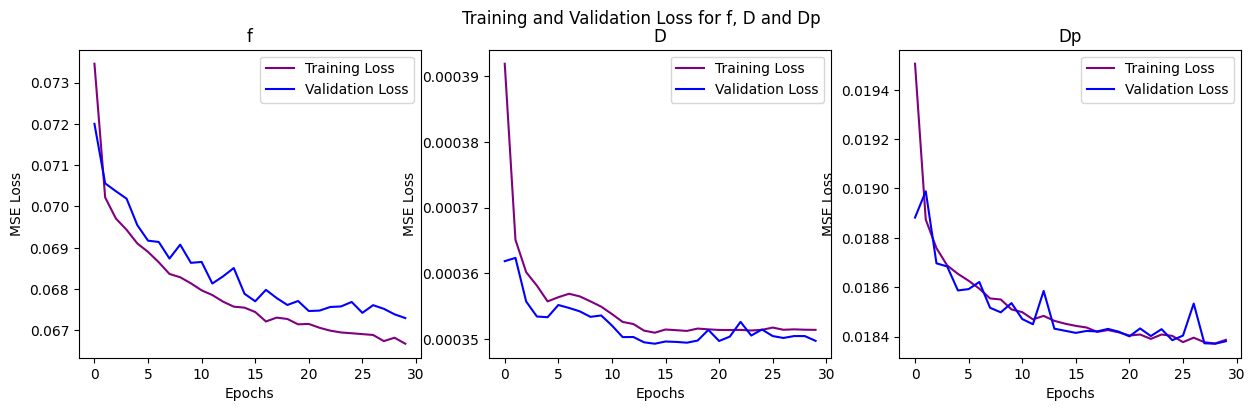

In [83]:
# Choosing the best parameters of the model
model_J, trainloader, inferloader, testloader, device, loss_module, optimizer = initialization("test", learning_rate = 0.1, optimizer="Adagrad", batch_size = 4, activation="ELU", width = 15, n_outputs=3, sims=100000)
train_losses_f, train_losses_D, train_losses_Dp, val_losses_f, val_losses_D, val_losses_Dp, total_loss, model_J1 = train_network_scaling(model_J, trainloader, inferloader, device, loss_module, optimizer, epochs=30)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Training and Validation Loss for f, D and Dp')

axs[0].plot(train_losses_f, label="Training Loss", color="purple")
axs[0].plot(val_losses_f, label="Validation Loss", color="blue")
axs[0].set_title("f")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MSE Loss")
axs[0].legend()

axs[1].plot(train_losses_D, label="Training Loss", color="purple")
axs[1].plot(val_losses_D, label="Validation Loss", color="blue")
axs[1].set_title("D")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("MSE Loss")
axs[1].legend()

axs[2].plot(train_losses_Dp, label="Training Loss", color="purple")
axs[2].plot(val_losses_Dp, label="Validation Loss", color="blue")
axs[2].set_title("Dp")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("MSE Loss")
axs[2].legend()

plt.show()

# For scoring 7.5+
So far, you have been working with simulated data (taken care of by Data_loader.py). For such data, we know the ground truth values. However, in vivo, we have no way of knowing the ground truth. How will our network perform? Note that for this exercise you may need ot play with hyperparameters and design choices to train.

K.	Use the network, as trained in (J) and apply it to real-world data which is provided by running “dataval, valid_id, bvalues = hf.load_real_data(eval=True)”.
- You will need to export you trained network in the return of the "train_network" function
- you will need to apply it to the "dataval" from hf.load_real_data(eval=True)
- you will then want to put the outputs through "hf.plot_example(np.squeeze(D_out), valid_id,0.003)", "hf.plot_example(np.squeeze(f_out), valid_id,0.7)" and "hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)", with the predicted D, f and Dp being D_out, f_out and Dp_out.

Note that alongside your plot (the first), also a conventional least squares fit is provided as a reference. Show the resulting parameter maps. How does your approach compare? Why do you think your particular approach would look better/worse?

L.	Ideally, you would train your network on real-world data. However, in this particular case, it is hard to get gold standard references. Luckily, we can use our understanding of physics, and of how stuff “should behave” to work our way around this. You will redesign your network loss, such that it can train on data without any gold standard references! Instead of placing the L2 loss on f_pred v.s. f_ref. Currently, the network is learning to minimize the difference between predicted fpred and the ground truth referene ftrue. In vivo, we may not have these references. To overcome this, we will now introduce a physics-informed loss. Use the IVIM equation [1] to propogate the predictions (D, f and Dp) into the signal space (S). Then, take e.g. the mean-square-error between the predicted signal and the input signal. Note that you will need to use torch functions (instead of numpy functions) to ensure you can backpropogate the loss through the equation into the network. You can train this network on the simulated data from earlier exercises. But it should also be able to train it on the in vivo data from "datatrain, bvalues = hf.load_real_data(eval=False)". This ensures that the network is use to looking at "real" data. Optimize the network’s training using the real data provided (“test_in_vivo.py”; datatrain). Evaluate the network on the same data as in 1 (data, valid_id, bvalues = dl.load_real_data(eval=True)). How does it perform?


Load patient data 

Patient data loaded

Load patient data 

Patient data loaded

training data is 103608 long
validation data is 5139 long
Test Loss (f): 0.675728
Test Loss (D): 0.000444
Test Loss (Dp): 0.004380
Total Test Loss: 0.680553
Load patient data 



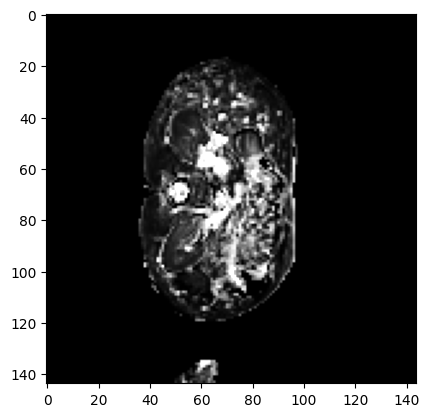

Load patient data 



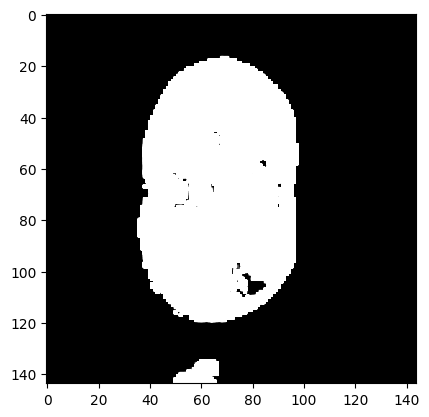

Load patient data 



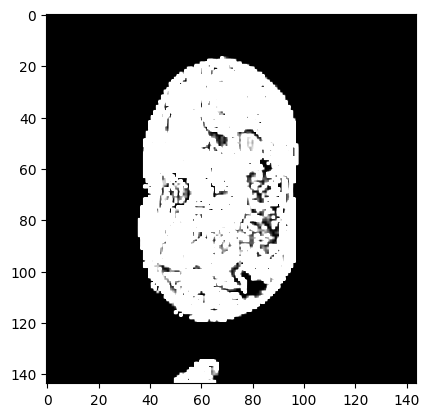

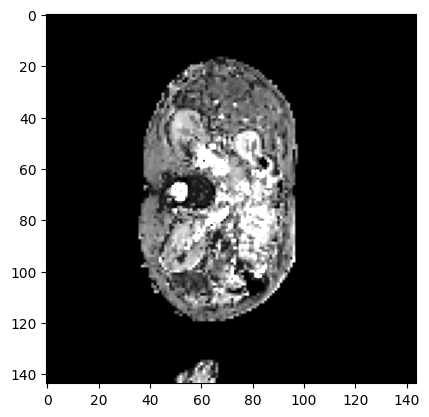

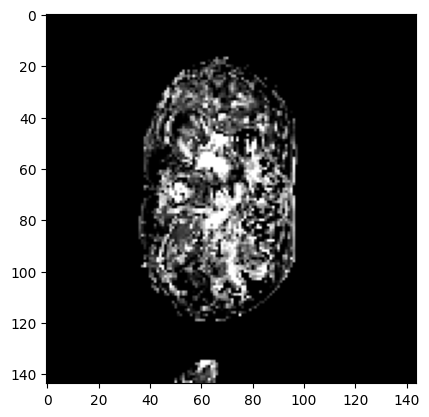

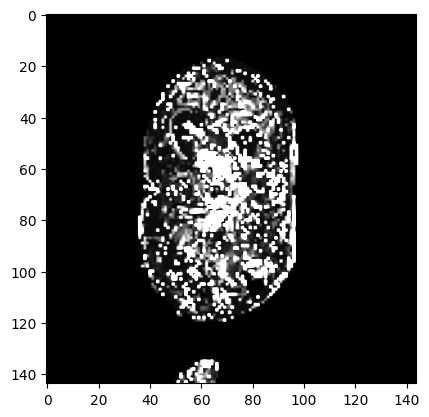

In [84]:
datatrain, bvalues = hf.load_real_data(eval=False)
dataval, valid_id, bvalues = hf.load_real_data(eval=True)
print('training data is ' + str(len(datatrain)) + ' long')
print('validation data is ' + str(len(dataval)) + ' long')

def test_network_updated(loss_module, testloader, device, model = model_J1):
    model.eval()  # Set model to evaluation mode

    # Initialize loss accumulators
    test_loss_f, test_loss_D, test_loss_Dp = 0, 0, 0
    SD_test_f, SD_test_D, SD_test_Dp = 0, 0, 0
    sys_test_f, sys_test_D, sys_test_Dp = 0, 0, 0

    # Store predictions
    f_out_list, D_out_list, Dp_out_list = [], [], []

    # Loop over test data
    for batch in testloader:
        x = torch.tensor(batch[:12], dtype=torch.float32, device=device).view(1, 12).to(device)  # Ensure correct shape
        f_true = torch.tensor(batch[2], dtype=torch.float32, device=device).flatten()
        D_true = torch.tensor(batch[1], dtype=torch.float32, device=device).flatten()
        Dp_true = torch.tensor(batch[3], dtype=torch.float32, device=device).flatten()

        if x.dim() == 1:  # If x is 1D, reshape it to 2D
            x = x.view(1, -1)

        outputs = model(x)
        f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]
    

        """ # Convert x to a PyTorch tensor if it's a NumPy array
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32, device=device)

        # If x is not structured as (input, D, f, Dp), assume a single batch
        if not isinstance(x, (tuple, list)):
            batch = x.to(device)  # Assume x is already input features
            f_true = torch.zeros(batch.shape[0], device=device)  # Placeholder
            D_true = torch.zeros(batch.shape[0], device=device)
            Dp_true = torch.zeros(batch.shape[0], device=device)
        else:
            batch = x[0].to(device)  # Extract input features
            f_true = torch.flatten(x[2].to(device))
            D_true = torch.flatten(x[1].to(device))
            Dp_true = torch.flatten(x[3].to(device))

        # Ensure batch has correct shape
        if batch.dim() == 0:  # If scalar, expand
            batch = batch.unsqueeze(0)
        elif batch.dim() == 1:  # If (12,), reshape to (1, 12)
            batch = batch.unsqueeze(0)

        # Forward pass
        with torch.no_grad():
            outputs = model(batch)
            f_pred, D_pred, Dp_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2]
 """
        # Store predictions
        f_out_list.append(f_pred.detach().numpy())
        D_out_list.append(D_pred.detach().numpy())
        Dp_out_list.append(Dp_pred.detach().numpy())

        # Compute loss
        loss_f = loss_module(f_pred, f_true) 
        loss_D = loss_module(D_pred, D_true) * 0.001 # Scale factor
        loss_Dp = loss_module(Dp_pred, Dp_true) * 0.01  # Scale factor

        # Accumulate losses
        test_loss_f += loss_f.item()
        test_loss_D += loss_D.item()
        test_loss_Dp += loss_Dp.item()

        # Compute error metrics
        SD_f, sys_f = hf.error_metrics(f_pred.detach().numpy(), f_true.detach().numpy())
        SD_D, sys_D = hf.error_metrics(D_pred.detach().numpy(), D_true.detach().numpy())
        SD_Dp, sys_Dp = hf.error_metrics(Dp_pred.detach().numpy(), Dp_true.detach().numpy())

        SD_test_f += SD_f**2
        SD_test_D += SD_D**2
        SD_test_Dp += SD_Dp**2
        sys_test_f += sys_f
        sys_test_D += sys_D
        sys_test_Dp += sys_Dp

    # Compute mean losses and errors
    num_samples = len(testloader)
    test_loss_f /= num_samples
    test_loss_D /= num_samples
    test_loss_Dp /= num_samples

    SD_test_f = np.sqrt(SD_test_f / num_samples)
    SD_test_D = np.sqrt(SD_test_D / num_samples)
    SD_test_Dp = np.sqrt(SD_test_Dp / num_samples)

    sys_test_f /= num_samples
    sys_test_D /= num_samples
    sys_test_Dp /= num_samples

    # Convert lists to numpy arrays
    f_out = np.squeeze(np.array(f_out_list))
    D_out = np.squeeze(np.array(D_out_list))
    Dp_out = np.squeeze(np.array(Dp_out_list))

    return test_loss_f, test_loss_D, test_loss_Dp, f_out, D_out, Dp_out

# Run the function
test_loss_f, test_loss_D, test_loss_Dp, f_out, D_out, Dp_out = test_network_updated(loss_module, dataval, device, model = model_J)

# Print results
print(f"Test Loss (f): {test_loss_f:.6f}")
print(f"Test Loss (D): {test_loss_D:.6f}")
print(f"Test Loss (Dp): {test_loss_Dp:.6f}")
print(f"Total Test Loss: {test_loss_f + test_loss_D + test_loss_Dp:.6f}")

# Plot predictions
hf.plot_example(f_out, valid_id, 0.7)
hf.plot_example(D_out, valid_id, 0.003)
hf.plot_example(Dp_out, valid_id, 0.1)
hf.plot_ref()


### you can compare supervised and self-supervised fits

In [38]:
import torch.optim as optim

def ivim_signal(bvalues, f, D, Dp, S0 = 1.0):
    """ Compute the IVIM signal model """
    bvalues = bvalues.view(1, -1)

    return S0 * (f.unsqueeze(1) * torch.exp(-bvalues * Dp.unsqueeze(1)) + 
                 (1 - f.unsqueeze(1)) * torch.exp(-bvalues * D.unsqueeze(1)))

def train_network_ivim(model, trainloader, inferloader, device, optimizer, epochs=200, bvalues=bvalues):
    """ Train network using a physics-informed loss based on the IVIM model """
    train_losses, val_losses = [], []
    loss_module = nn.MSELoss(reduction='mean').to(device)
    # trainloader = torch.tensor(trainloader, dtype = torch.float32)
   
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in trainloader:
            optimizer.zero_grad()
            bvalues = bvalues.clone().detach().to(dtype=torch.float32, device=device)

            x = torch.tensor(batch[:12], dtype = torch.float32, device = device).view(1, 12).to(device)  # Input signal S(b)
                       
            raw_outputs = model(x)
            f_pred, D_pred, Dp_pred = raw_outputs[:, 0], raw_outputs[:, 1], raw_outputs[:, 2]
           
            # Compute the IVIM predicted signal
            S_pred = ivim_signal(bvalues, f_pred, D_pred, Dp_pred, S0 = 1.0)
           
            # Physics-informed loss: MSE between predicted signal and input signal
            loss = loss_module(S_pred, x)
            train_loss += loss.item()
           
            loss.backward()
            optimizer.step()
       
        train_losses.append(train_loss / len(trainloader))
       
        # Validation phase
        model.eval()
        val_loss = 0
        f_out, D_out, Dp_out = [], [], []
        
        for batch in inferloader:
            x = torch.tensor(batch[:12], dtype = torch.float32, device = device).view(1, 12).to(device) 
            
            raw_outputs = model(x)
            f_pred, D_pred, Dp_pred = raw_outputs[:, 0], raw_outputs[:, 1], raw_outputs[:, 2]
            
            S_pred = ivim_signal(bvalues, f_pred, D_pred, Dp_pred, S0 = 1.0)
            
            loss = loss_module(S_pred, x)
            val_loss += loss.item()
            f_out.append(f_pred.detach().cpu().numpy())
            D_out.append(D_pred.detach().cpu().numpy())
            Dp_out.append(Dp_pred.detach().cpu().numpy())

       
        val_losses.append(val_loss / len(inferloader))


        # Log metrics to Weights & Biases
        wandb.init()
        if epoch % 10 == 0:
            wandb.log({
                "loss/train": train_losses[-1],
                "loss/val": val_losses[-1]
            })
            print(f"Epoch {epoch}: Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")
   
    wandb.finish()


    # Plot parameter maps for comparison
    hf.plot_example(np.squeeze(D_out), valid_id, 0.003)
    hf.plot_example(np.squeeze(f_out), valid_id, 0.7)
    hf.plot_example(np.squeeze(Dp_out), valid_id, 0.1)
    hf.plot_ref()
       
    return train_losses, val_losses, model

In [39]:
datatrain, bvalues = hf.load_real_data(eval=False)
dataval, valid_id, bvalues = hf.load_real_data(eval=True)

train_losses, val_losses, model = train_network_ivim(model, datatrain, dataval, device, optimizer, epochs = 50, bvalues = bvalues)

plt.plot(train_losses, label="Training Loss", color="purple")
plt.plot(val_losses, label="Validation Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()


Load patient data 

Patient data loaded

Load patient data 

Patient data loaded



AttributeError: 'numpy.ndarray' object has no attribute 'clone'

In [17]:
datatrain, bvalues = hf.load_real_data(eval=True)
dataval, valid_id, bvalues = hf.load_real_data(eval=True)
train_losses, val_losses, model = train_network_ivim(model, datatrain, dataval, device, optimizer, epochs = 50, scaling_factor=100, bvalues = bvalues)

plt.plot(train_losses, label="Training Loss", color="purple")
plt.plot(val_losses, label="Validation Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()


Load patient data 

Patient data loaded



ValueError: too many values to unpack (expected 2)